# NEW

In [1]:
from bbq.decoder import d_osd, bp_osd, osd
import numpy as np
from ldpc import BpDecoder, bposd_decoder
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import matplotlib.pyplot as plt
import json
import datetime

In [2]:
physical_error = np.flip(np.logspace(-1.7, -0.7, 10))
ext_physical_error = np.flip(np.logspace(-1, -0.8, 10))

In [3]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

In [26]:
def line_of_best_fit(x, results, bounds):
    line_coef = {}
    for d in results:
        a, b = np.polyfit(np.log10(x[0:bounds[d]]), np.log10(results[d][0:bounds[d]]), 1)
        line_coef[d] = (a, b)
    return line_coef

C:\Users\elean\AppData\Local\Temp\ipykernel_21844\1591005615.py:5: RuntimeWarning: divide by zero encountered in divide
  plot_results[d] = num_failures[d] / (np.array(results[d]))
C:\Users\elean\AppData\Local\Temp\ipykernel_21844\1591005615.py:6: RuntimeWarning: invalid value encountered in sqrt
  plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])


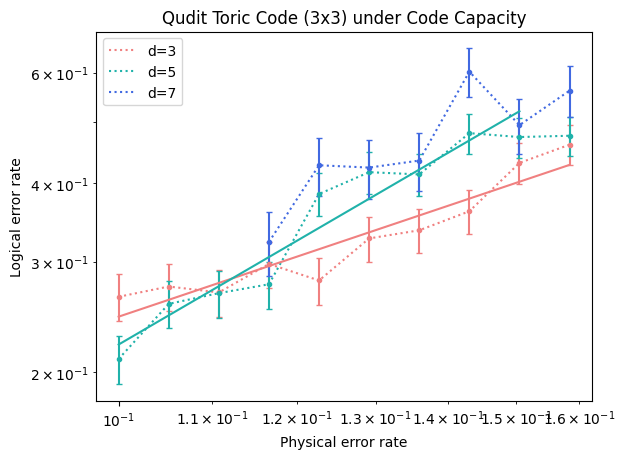

In [38]:
results = {3: [379, 365, 373, 336, 357, 306, 297, 277, 232, 217],
           5: [476, 389, 374, 362, 260, 240, 242, 208, 211, 210],
           7: [0, 0, 0, 155, 117, 118, 115, 83, 101, 89]}
plot_num_failures = {3: 100,
                5: 100,
                7: 50}
bounds = {3: 10, 5: 9, 7: 10}

x = np.flip(ext_physical_error)
plot_results, plot_error_bars = process_results(results, plot_num_failures)
line_coef = line_of_best_fit(x, plot_results, bounds)

plt.loglog(x, plot_results[3], color='lightcoral', linestyle='dotted')
plt.loglog(x, plot_results[5], color='lightseagreen', linestyle='dotted')
plt.loglog(x, plot_results[7], color='royalblue', linestyle='dotted')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.plot(x, 10**(line_coef[3][1]) * x**line_coef[3][0], color='lightcoral')
plt.plot(x[0:bounds[5]], (10**(line_coef[5][1]) * x**line_coef[5][0])[0:bounds[5]], color='lightseagreen')
plt.plot(x, 10**(line_coef[7][1]) * x**line_coef[7][0], color='royalblue')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qudit Toric Code (3x3) under Code Capacity');

## Joschka threshold

In [106]:
# Code capacity model for qubit Toric code with varying distance using ldpc package

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 1000
#ldpc_results = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [3]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    n_qudits = bb.hx.shape[1]
    # res = results_cap_qubit[d]
    res = []
    for ind, p in enumerate(np.logspace(-1.7, -0.7, 10)):
    # for p in [0.01]:
        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue

        # Construct error probability
        channel_prob_x = np.ones(n_qudits) * p  # more complicated for qudits!!!

        x_prior = np.zeros((n_qudits, bb.field), dtype=float)

        for i, prob in enumerate(channel_prob_x):
            x_prior[i, 0] = 1 - prob
            for j in range(1, bb.field):
                x_prior[i, j] = prob / (bb.field - 1)

        while failures < num_failures:
            # Generate syndrome
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Decode
            bp_osd_d = bposd_decoder(bb.hx, channel_probs=x_prior[:, 1], max_iter=max_iter, bp_method='product_sum', osd_order=0)
            guessed_error = bp_osd_d.decode(syndrome)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                # print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        # res[1+ind] = num_trials
        res.append(num_trials)
        print(f'Finished p={p} for d={d} with num_trials={num_trials}')
    print(f'Completed d={d}')
    ldpc_results[d] = res

c:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\bbq_venv\Lib\site-packages\ldpc\_legacy_ldpc_v1\_legacy_bposd_decoder.py:45: UserWarning: This is the old syntax for the `bposd_decoder` from `ldpc v1`. Use the `BpOsdDecoder` class from `ldpc v2` for additional features.
  warnings.warn(


Finished p=0.0199526231496888 for d=3 with num_trials=416
Finished p=0.025769803745148787 for d=3 with num_trials=385
Finished p=0.033282981394546204 for d=3 with num_trials=213
Finished p=0.042986623470822764 for d=3 with num_trials=105
Finished p=0.05551935914386209 for d=3 with num_trials=112
Finished p=0.07170600970409613 for d=3 with num_trials=36
Finished p=0.09261187281287937 for d=3 with num_trials=22
Finished p=0.11961283330787534 for d=3 with num_trials=25
Finished p=0.15448591479026755 for d=3 with num_trials=7
Finished p=0.19952623149688797 for d=3 with num_trials=10
Completed d=3


In [107]:
ldpc_results

{5: [4039, 1692, 489, 204, 107, 33, 32, 22, 13, 8],
 7: [23580, 8294, 1478, 558, 145, 137, 23, 19, 7, 12],
 3: [416, 385, 213, 105, 112, 36, 22, 25, 7, 10]}

In [140]:
save_data = {}
save_data['current_round'] = {'code' : d, 'error_rate' : p,'num_trials' : num_trials, 'failures' : failures}
save_data['noise_model'] = 'code_capacity'
save_data['rounds'] = None
save_data['qec_codes'] = [3, 5, 7]
save_data['num_failures'] = {3 : 5, 5 : 5, 7 : 5}
save_data['error_rates'] = list(np.logspace(-1.7, -0.7, 10))
save_data['results'] = ldpc_results
# save_data_filename = f'results_{datetime.datetime.now().strftime("%d-%m-%Y_%H-%M")}.json'

In [141]:
json.dump(save_data, open(save_data_filename, 'w'), indent=4)

In [104]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

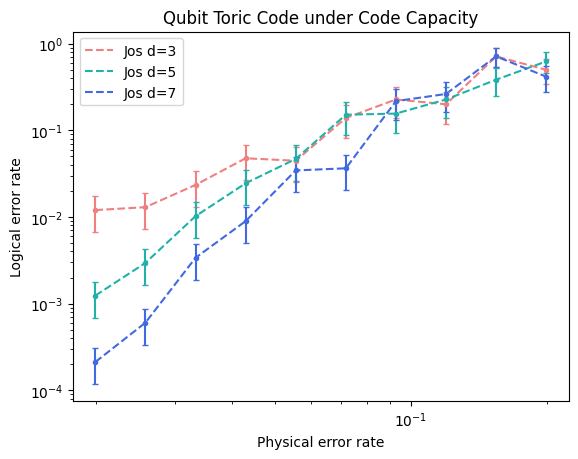

In [118]:
# Plotting BP+OSD0

x = np.logspace(-1.7, -0.7, 10)
num_failures = {3 : 5, 5 : 5, 7 : 5}
jos_plot_results, plot_error_bars = process_results(ldpc_results, num_failures)

plt.loglog(x, jos_plot_results[3], '--', color='lightcoral')
plt.loglog(x, jos_plot_results[5], '--', color='lightseagreen')
plt.loglog(x, jos_plot_results[7], '--', color='royalblue')

plt.errorbar(x, jos_plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, jos_plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, jos_plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['Jos d=3', 'Jos d=5', 'Jos d=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qubit Toric Code under Code Capacity');

## Check osd against Joschka

In [94]:
error = debug['failed_error'][0]
syndrome = debug['failed_syndromes'][0]
posterior = debug['failed_osd_posteriors'][0]

In [95]:
guessed_error, decoder_success, bp_success, posterior = osd(bb.field, bb.hx, syndrome, posterior, certainties=None, order=0, debug=True)
error_difference = (error - guessed_error) % 2
logical_effect = (np.array(bb.x_logicals) @ error_difference) % 2
print(logical_effect)

[0 1]


In [96]:
guessed_error, decoder_success, bp_success, posterior = bp_osd(bb.field, bb.hx, syndrome, x_prior, max_iter=1000, order=0, debug=True)
error_difference = (error - guessed_error) % 2
logical_effect = (np.array(bb.x_logicals) @ error_difference) % 2
print(logical_effect)

[0 1]


In [97]:
np.log(1/posterior[:, 1])[0]

np.float64(3.758730258445461)

In [101]:
(guessed_error == jos_guessed_error).all()

np.True_

In [99]:
jos_bp_osd = bposd_decoder(bb.hx, channel_probs=x_prior[:, 1], max_iter=1000, bp_method='product_sum', osd_order=0)
jos_guessed_error = jos_bp_osd.decode(syndrome)
jos_error_difference = (error - jos_guessed_error) % 2
jos_logical_effect = (np.array(bb.x_logicals) @ jos_error_difference) % 2
print(logical_effect)

[0 1]


In [100]:
jos_bp_osd.log_prob_ratios[0]

np.float64(3.7587302584454596)

### Generating fails

In [93]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 1
max_iter = 1000
p = 0.07
d = 5

results = {}
res = []
debug = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

bb = BivariateBicycle(a, b, d, d, 1)
lx = bb.x_logicals
n_qudits = bb.hx.shape[1]

bp_errors, osd_errors = 0, 0
bp_successes, osd_success = 0, 0

failed_osd_posteriors = []
failed_syndromes = []
failed_errors = []

failures = 0
num_trials = 0

# Construct error probability
channel_prob_x = np.ones(n_qudits) * p

x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

for i, prob in enumerate(channel_prob_x):
    x_prior[i, 0] = 1 - prob
    for j in range(1, 2):
        x_prior[i, j] = prob / (2 - 1)

while osd_errors < num_failures:
    # Generate syndrome
    error = np.zeros(n_qudits, dtype=int)
    error_mask = np.random.rand(n_qudits) < p
    for i in np.where(error_mask)[0]:
        error[i] = np.random.randint(1, bb.field)
    syndrome = (bb.hx @ error) % bb.field

    # Decode
    guessed_error, decoder_success, bp_success, posterior = bp_osd(bb.field, bb.hx, syndrome, x_prior, max_iter, order=0, debug=True)
    error_difference = (error - guessed_error) % 2
    logical_effect = (np.array(lx) @ error_difference) % 2

    # Check success
    if np.any(logical_effect != 0):
        failures += 1
        if bp_success:
            bp_errors += 1
            print(f'Found {bp_errors} bp failures, with num_trials : {num_trials}')
        else:
            osd_errors += 1
            print(f'Found {osd_errors} osd failures, with num_trials : {num_trials}')
            failed_osd_posteriors.append(posterior)
            failed_syndromes.append(syndrome)
            failed_errors.append(error)
    else:
        if bp_success:
            bp_successes += 1
        else:
            osd_success += 1

    if num_trials % 100 == 0:
        save_data['num_trials'] = num_trials
        save_data['failures'] = failures
        json.dump(save_data, open(save_data_filename, 'w'), indent=4)

    num_trials += 1

    debug['bp_errors'] = bp_errors
    debug['osd_errors'] = osd_errors
    debug['bp_success'] = bp_successes
    debug['osd_success'] = osd_success
    debug['failed_osd_posteriors'] = failed_osd_posteriors
    debug['failed_syndromes'] = failed_syndromes
    debug['failed_error'] = failed_errors

    res.append(num_trials)

results[d] = res

Found 1 bp failures, with num_trials : 6
Found 1 osd failures, with num_trials : 9


# OLD

In [1]:
from utils import *
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle, Polygon
import galois
from scipy.sparse import coo_matrix, hstack

In [2]:
h_eff = np.array([[0, 0, 1, 1], [0, 1, 1, 1], [0, 1, 1, 0]])
h_eff

array([[0, 0, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 0]])

In [3]:
prior = np.array([[0.8, 0.2], [0.3, 0.7], [0.1, 0.9], [0.5, 0.5]])
prior

array([[0.8, 0.2],
       [0.3, 0.7],
       [0.1, 0.9],
       [0.5, 0.5]])

In [2]:
def _err_to_det(h_eff):
    det, err = np.nonzero(h_eff)
    err_neighbourhood = {}
    for i in range(len(err)):
        if err[i] not in err_neighbourhood:
            err_neighbourhood[int(err[i])] = [int(det[i])]
        else:
            err_neighbourhood[int(err[i])].append(int(det[i]))
    return err_neighbourhood

def _det_to_err(h_eff):
    det, err = np.nonzero(h_eff)
    det_neighourhood = {}
    for i in range(len(det)):
        if det[i] not in det_neighourhood:
            det_neighourhood[int(det[i])] = [int(err[i])]
        else:
            det_neighourhood[int(det[i])].append(int(err[i]))
    return det_neighourhood

In [4]:
# Initialise

n_detectors, n_errors = h_eff.shape
field = 2
max_iter = 1
# syndrome = np.array([0, 0, 0])

err_neighbourhood = _err_to_det(h_eff)
det_neighbourhood = _det_to_err(h_eff)

posteriors = np.zeros(prior.shape)

Q = np.zeros((n_errors, n_detectors, field))
for i in range(n_errors):
    if i in err_neighbourhood:
        dets = err_neighbourhood[i]
        Q[i, dets, :] = prior[i]

P = np.zeros((n_detectors, n_errors, field))

In [167]:
# Initialise toric

d = 5
p = 0.1

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))
bb = BivariateBicycle(a, b, d, d, 1)
lz = bb.z_logicals

# Generate syndrome
n_qudits = bb.hx.shape[1]
real_error = np.zeros(n_qudits, dtype=int)
error_mask = np.random.rand(n_qudits) < p
for i in np.where(error_mask)[0]:
    real_error[i] = np.random.randint(1, bb.field)
syndrome = (bb.hx @ real_error) % bb.field

# Construct error probability
channel_prob_x = np.ones(n_qudits)
channel_prob_x *= (1/n_qudits) * p

x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

for i, prob in enumerate(channel_prob_x):
    x_prior[i, 0] = 1 - prob
    for j in range(1, 2):
        x_prior[i, j] = prob / (2 - 1)

h_eff = bb.hx
prior = x_prior
print(f'{syndrome=}')

# Decode
# guessed_error, decoder_success = bp_osd_decode(bb, syndrome, x_prior, bb.hx, max_iter)

syndrome=array([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0])


In [33]:
error_difference = (real_error - error) % 2
logical_effect = (np.array(lz) @ error_difference) % 2
print(f'{logical_effect=}')

logical_effect=array([1, 0])


In [13]:
# Step 1: pass check to error messages

for i in det_neighbourhood:
    errs = det_neighbourhood[i]

    # Isolate the relevant error messages
    convolution = Q[errs, i, :].copy()

    # Fourier transform the error messages
    convolution = np.fft.fft(convolution, axis=1)

    for j in range(len(errs)):
        # Remove the j-th error message from the convolution
        sub_convolution = np.delete(convolution, j, axis=0)

        # Compute the product of the transformed error messages
        sub_convolution = np.prod(sub_convolution, axis=0)

        # Inverse Fourier transform the product to find the convolution
        sub_convolution = np.fft.ifft(sub_convolution, axis=0)

        # Pass message
        for k in range(field):
            P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]

C:\Users\elean\AppData\Local\Temp\ipykernel_11404\1416376077.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]


In [14]:
# Step 2: pass error to check messages

error = np.zeros(n_errors, dtype=int)

for i in err_neighbourhood:
    dets = err_neighbourhood[i]

    # Isolate the relevant check messages
    posterior = P[dets, i, :].copy()

    for j in range(len(dets)):
        # Remove the j-th check message from the posterior
        sub_posterior = np.delete(posterior, j, axis=0)

        # Compute the product of probabilities
        sub_posterior = np.prod(sub_posterior, axis=0) * prior[i, :]

        #################################################
        # WARNING: sub_posterior is no longer normalised!
        #################################################

        # Pass message
        Q[i, dets[j], :] = sub_posterior / np.sum(sub_posterior)

    # Step 3: calculate posterior and make hard decision on errors
    posterior = np.prod(posterior, axis=0) * prior[i, :]
    print(f'Posterior for error {i}: {posterior}')
    posterior_sum = np.sum(posterior)
    for j in range(len(posterior)):
        posterior[j] = posterior[j] / (posterior_sum - posterior[j])  ####### do I have blowing up problems here???
        posteriors[i, :] = posterior  ############### does OSD want the likelihoods or the probabilities??? (I think likelihoods here)
        if posterior[j] >= 1:
            error[i] = j
            ##############################################
            # WARNING: may overwrite if there are 2 error types (eg X and X^2) that are likely (ONLY happens when eg likelihoods are (0, 1, 1) so the > instead of >= would fix this)
            ##############################################

    print(f'{error=}')

    # Step 4: check convergence
    if np.all(h_eff @ error % field == syndrome):
        print(f'Whoo! The error is {error}')
    else:
        print('boo did not converge on a valid solution (or potentially did not have high enough probabilities? only in qudit case?)')
        print(f'and the posteriors are: \n {posteriors}')

Posterior for error 0: [2.80475582e-02 7.69778926e-06]
error=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])
boo did not converge on a valid solution (or potentially did not have high enough probabilities? only in qudit case?)
and the posteriors are: 
 [[3.64358613e+03 2.74454881e-04]
 [1.73574495e+02 5.76121510e-03]
 [1.52732301e+02 6.54740347e-03]
 [1.70206746e-02 5.87520779e+01]
 [1.01606895e+04 9.84185176e-05]
 [3.79831799e+03 2.63274429e-04]
 [2.21318415e-02 4.51837685e+01]
 [1.13510522e+02 8.80975600e-03]
 [3.67279510e+01 2.72272200e-02]
 [4.48933496e+03 2.22750142e-04]
 [5.98837855e+02 1.66990111e-03]
 [1.29028597e-01 7.75021990e+00]
 [4.95099342e+03 2.01979667e-04]
 [4.53767853e+02 2.20377004e-03]
 [4.73783820e+01 2.11066726e-02]
 [4.80371888e-02 2.08172049e+01]
 [7.17461712e+02 1.39380260e-03]
 [3.45895008e+04 2.89105069e-05]
 [3.04918913e+03 3.27956043e-

In [15]:
error

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0])

In [177]:
posteriors

array([[4.99000000e+02, 2.00400802e-03],
       [4.99000000e+02, 2.00400802e-03],
       [1.38060178e+07, 7.24321824e-08],
       [1.80356858e-02, 5.54456320e+01],
       [1.80356858e-02, 5.54456320e+01],
       [1.38060178e+07, 7.24321824e-08],
       [1.38060178e+07, 7.24321824e-08],
       [4.99000000e+02, 2.00400802e-03],
       [4.99000000e+02, 2.00400802e-03],
       [4.99000000e+02, 2.00400802e-03],
       [1.38060178e+07, 7.24321824e-08],
       [4.99000000e+02, 2.00400802e-03],
       [4.99000000e+02, 2.00400802e-03],
       [1.38060178e+07, 7.24321824e-08],
       [4.99000000e+02, 2.00400802e-03],
       [1.38060178e+07, 7.24321824e-08],
       [1.80356858e-02, 5.54456320e+01],
       [1.38060178e+07, 7.24321824e-08],
       [1.38060178e+07, 7.24321824e-08],
       [4.99000000e+02, 2.00400802e-03],
       [4.99000000e+02, 2.00400802e-03],
       [1.80356858e-02, 5.54456320e+01],
       [1.38060178e+07, 7.24321824e-08],
       [4.99000000e+02, 2.00400802e-03],
       [4.990000

In [169]:
posteriors = np.array([[9.87948572e+09, 1.01219810e-10],
        [2.19518658e+05, 4.55542143e-06],
        [2.46408218e+13, 4.05274453e-14],
        [1.07263276e+13, 9.32244402e-14],
        [5.48581771e+05, 1.82288230e-06],
        [8.92347096e+10, 1.12064688e-11],
        [2.46893346e+13, 4.05198941e-14],
        [           np.inf, 1.10137710e-24],
        [           np.inf, 2.45679984e-19],
        [2.16759461e+07, 4.61340878e-08],
        [2.16759461e+07, 4.61340878e-08],
        [           np.inf, 2.45679984e-19],
        [           np.inf, 1.10137710e-24],
        [2.46893346e+13, 4.05198941e-14],
        [8.92347096e+10, 1.12064688e-11],
        [5.48581771e+05, 1.82288230e-06],
        [1.07263276e+13, 9.32244402e-14],
        [2.46408218e+13, 4.05274453e-14],
        [2.19518658e+05, 4.55542143e-06],
        [9.87948572e+09, 1.01219810e-10],
        [5.05824856e+01, 1.97696888e-02],
        [1.26092096e+09, 7.93071157e-10],
        [2.16796321e+07, 4.61262440e-08],
        [1.26092096e+09, 7.93071157e-10],
        [5.05824856e+01, 1.97696888e-02],
        [1.26092096e+09, 7.93071157e-10],
        [2.19518658e+05, 4.55542143e-06],
        [2.46893346e+13, 4.05198941e-14],
        [           np.inf, 2.45679984e-19],
        [1.07263276e+13, 9.32244402e-14],
        [2.16796321e+07, 4.61262440e-08],
        [2.46408218e+13, 4.05274453e-14],
        [           np.inf, 1.10137710e-24],
        [           np.inf, 1.10137710e-24],
        [2.46408218e+13, 4.05274453e-14],
        [1.26092096e+09, 7.93071157e-10],
        [1.07263276e+13, 9.32244402e-14],
        [           np.inf, 2.45679984e-19],
        [2.46893346e+13, 4.05198941e-14],
        [2.19518658e+05, 4.55542143e-06],
        [5.05824856e+01, 1.97696888e-02],
        [5.48581771e+05, 1.82288230e-06],
        [2.16759461e+07, 4.61340878e-08],
        [8.92347096e+10, 1.12064688e-11],
        [9.87948572e+09, 1.01219810e-10],
        [5.05824856e+01, 1.97696888e-02],
        [9.87948572e+09, 1.01219810e-10],
        [8.92347096e+10, 1.12064688e-11],
        [2.16759461e+07, 4.61340878e-08],
        [5.48581771e+05, 1.82288230e-06]])
# h_eff = np.array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
#       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
#       [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
#       [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
#       [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
#       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0],
#       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
#       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
#       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]])
syndrome = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0])
real_error = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0])
lz = [np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1]),
 np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0])]

In [171]:
test = np.delete(posteriors, 0, axis=1)

In [106]:
test

array([[3.06176150e-04],
       [3.42339376e-04],
       [4.49379888e-07],
       [3.42339376e-04],
       [3.06176150e-04],
       [4.49379888e-07],
       [8.26065232e-01],
       [8.26065232e-01],
       [2.22593999e-04],
       [4.49379888e-07],
       [2.22593999e-04],
       [4.49379888e-07],
       [3.42339376e-04],
       [8.26065232e-01],
       [3.06176150e-04],
       [3.06176150e-04],
       [8.26065232e-01],
       [3.42339376e-04]])

In [172]:
col_rank_perm = np.argsort(-test, axis=None)
col_rank_inv_perm = np.empty_like(col_rank_perm)
col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))
col_rank_inv_perm, col_rank_perm

(array([25,  6, 35, 33,  9, 26, 39, 46, 43, 15, 12, 42, 47, 38, 27, 10, 31,
        34,  4, 24,  1, 20, 17, 19,  0, 21,  7, 41, 44, 30, 16, 36, 48, 49,
        37, 18, 32, 45, 40,  5,  2,  8, 14, 29, 23,  3, 22, 28, 13, 11]),
 array([24, 20, 40, 45, 18, 39,  1, 26, 41,  4, 15, 49, 10, 48, 42,  9, 30,
        22, 35, 23, 21, 25, 46, 44, 19,  0,  5, 14, 47, 43, 29, 16, 36,  3,
        17,  2, 31, 34, 13,  6, 38, 27, 11,  8, 28, 37,  7, 12, 32, 33]))

In [173]:
posteriors[col_rank_perm]

array([[5.05824856e+01, 1.97696888e-02],
       [5.05824856e+01, 1.97696888e-02],
       [5.05824856e+01, 1.97696888e-02],
       [5.05824856e+01, 1.97696888e-02],
       [2.19518658e+05, 4.55542143e-06],
       [2.19518658e+05, 4.55542143e-06],
       [2.19518658e+05, 4.55542143e-06],
       [2.19518658e+05, 4.55542143e-06],
       [5.48581771e+05, 1.82288230e-06],
       [5.48581771e+05, 1.82288230e-06],
       [5.48581771e+05, 1.82288230e-06],
       [5.48581771e+05, 1.82288230e-06],
       [2.16759461e+07, 4.61340878e-08],
       [2.16759461e+07, 4.61340878e-08],
       [2.16759461e+07, 4.61340878e-08],
       [2.16759461e+07, 4.61340878e-08],
       [2.16796321e+07, 4.61262440e-08],
       [2.16796321e+07, 4.61262440e-08],
       [1.26092096e+09, 7.93071157e-10],
       [1.26092096e+09, 7.93071157e-10],
       [1.26092096e+09, 7.93071157e-10],
       [1.26092096e+09, 7.93071157e-10],
       [9.87948572e+09, 1.01219810e-10],
       [9.87948572e+09, 1.01219810e-10],
       [9.879485

In [181]:
real_error[col_rank_perm]

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [187]:
best_solution[col_rank_perm]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [179]:
pivot_cols

[0,
 1,
 2,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 18,
 20,
 30,
 31,
 34,
 35,
 36,
 37,
 46]

In [175]:
GF = galois.GF(field)
H_gf = GF(h_eff.copy())
syndrome_gf = GF(syndrome.copy())

In [176]:
real_error_gf = GF(real_error.copy())

In [177]:
H_ordered_gf = H_gf[:, col_rank_perm]
priors_perm = prior[col_rank_perm]
H_ordered_gf

GF([[0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    ...,
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    [1, 0, 0, ..., 0, 0, 0]], order=2)

In [178]:
m, n = h_eff.shape

H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
m_ind = H_rref_gf.shape[0]
non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

H_rref_gf

GF([[0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 1, 1, 1],
    ...,
    [0, 0, 0, ..., 0, 0, 0],
    [0, 0, 0, ..., 1, 1, 1],
    [0, 0, 0, ..., 1, 1, 1]], order=2)

In [182]:
P = H_rref_gf[:, pivot_cols]
assert P.shape == (m_ind, m_ind)
############################
# Do I always have more error mechanisms than detectors for this assert?? ie it's (m, m) not (n, n)
############################
B = H_rref_gf[:, non_pivot_cols]

In [183]:
def sln_from(g):
    assert g.shape == (n - m_ind,)
    remainder =  syndrome_rref_gf - B @ g
    fix = np.linalg.solve(P, remainder)
    assert (P @ fix + B @ g == syndrome_rref_gf).all()

    score = 0
    sln = GF.Zeros(n)
    # Find prob of basis set
    for i in range(m_ind):
        p = priors_perm[pivot_cols[i], fix[i]]
        sln[pivot_cols[i]] = fix[i]
        if p > 0:
            score += np.log(p)
        else:
            score -= 1000
    
    for i in range(n - m_ind):
        p = priors_perm[non_pivot_cols[i], g[i]]
        sln[non_pivot_cols[i]] = g[i]
        if p > 0:
            score += np.log(p)
        else:
            score -= 1000

    # Check sln makes correct syndrome
    assert (H_rref_gf @ sln == syndrome_rref_gf).all()
    assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()

    assert ((h_eff @ sln[col_rank_inv_perm].__array__()) % field == syndrome).all()

    return np.array(sln[col_rank_inv_perm]), score

In [184]:
best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
assert ((h_eff @ best_solution) % field == syndrome).all()

In [185]:
best_solution

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [186]:
error_difference = (real_error - best_solution) % 2
logical_effect = (np.array(lz) @ error_difference) % 2
print(f'{logical_effect=}')

logical_effect=array([1, 0])


In [133]:
test[col_rank_perm]

array([[8.26065232e-01],
       [8.26065232e-01],
       [8.26065232e-01],
       [8.26065232e-01],
       [3.42339376e-04],
       [3.42339376e-04],
       [3.42339376e-04],
       [3.42339376e-04],
       [3.06176150e-04],
       [3.06176150e-04],
       [3.06176150e-04],
       [3.06176150e-04],
       [2.22593999e-04],
       [2.22593999e-04],
       [4.49379888e-07],
       [4.49379888e-07],
       [4.49379888e-07],
       [4.49379888e-07]])

In [119]:
r = real_error[col_rank_perm]
r_gf = GF(r)
r_gf

GF([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], order=2)

In [120]:
b = best_solution[col_rank_perm]
b_gf = GF(b)
b_gf

GF([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], order=2)

In [121]:
H_rref_gf @ b_gf

GF([0, 0, 0, 1, 0, 0, 1, 0], order=2)

In [122]:
H_rref_gf @ r_gf

GF([0, 0, 0, 1, 0, 0, 1, 0], order=2)

In [123]:
syndrome_rref_gf

GF([0, 0, 0, 1, 0, 0, 1, 0], order=2)

In [128]:
P @ b_gf[:8]

GF([0, 0, 0, 1, 0, 0, 1, 0], order=2)

In [129]:
P @ r_gf[:8]

GF([0, 0, 0, 0, 1, 1, 0, 0], order=2)

In [130]:
pivot_cols

[0, 1, 2, 4, 5, 6, 7, 14]

In [ ]:
# OSD

m, n = h_eff.shape

##################################################################################
# For qubits, do normal OSD (need to be careful with error powers for qudits *help*)
##################################################################################


# Step 1: order the errors by likelihood
col_rank_perm = np.argsort(-np.delete(posteriors, 0, axis=1), axis=None)
col_rank_inv_perm = np.empty_like(col_rank_perm)
col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))

# Step 2: create Galois field elements
GF = galois.GF(field)
H_gf = GF(h_eff.copy())
syndrome_gf = GF(syndrome.copy())

# Order the columns of h_gf and prior according to the ranking
H_ordered_gf = H_gf[:, col_rank_perm]
priors_perm = posteriors[col_rank_perm]

# Find the reduced row echelon form (RREF) and identify pivot columns
H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

# Select the first rank(h_gf) linearly independent columns as basis set in P, others in B
P = H_rref_gf[:, pivot_cols]
m_ind = P.shape[0]
assert P.shape == (m_ind, m_ind)
B = H_rref_gf[:, non_pivot_cols]

def sln_from(g):
    assert g.shape == (n - m_ind,)
    remainder =  syndrome_rref_gf - B @ g
    fix = np.linalg.solve(P, remainder)
    assert (P @ fix + B @ g == syndrome_rref_gf).all()

    score = 0
    sln = GF.Zeros(n)
    # Find prob of basis set
    for i in range(m_ind):
        p = priors_perm[pivot_cols[i], fix[i]]
        sln[pivot_cols[i]] = fix[i]
        if p > 0:
            score += np.log(p)
        else:
            score -= 1000
    
    for i in range(n - m_ind):
        p = priors_perm[non_pivot_cols[i], g[i]]
        sln[non_pivot_cols[i]] = g[i]
        if p > 0:
            score += np.log(p)
        else:
            score -= 1000

    # Check sln makes correct syndrome
    assert (H_rref_gf @ sln == syndrome_rref_gf).all()
    assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()

    assert ((h_eff @ sln[col_rank_inv_perm].__array__()) % field == syndrome).all()

    return np.array(sln[col_rank_inv_perm]), score

# OSD_0 solution
best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
assert ((h_eff @ best_solution) % field == syndrome).all()
pivot_col_labels = {col_rank_perm[c]: int(np.delete(posteriors, 0, axis=1).reshape(-1)[col_rank_perm[c]]) for c in pivot_cols}

# print(f'for debugging: {best_solution}, {True}, {[col_rank_perm[i] for i in pivot_cols]}, {pivot_col_labels}')

best_solution

AssertionError: 

In [179]:
P.shape

(24, 24)

In [180]:
m

25

In [113]:
np.all(h_eff @ best_solution % field == syndrome)

np.True_

In [1006]:
bp(h_eff, syndrome, Q, P, prior, field, 1000)

Whoo! The error is [0 1 0]


C:\Users\elean\AppData\Local\Temp\ipykernel_7568\3149370900.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]


(array([0, 1, 0]), True)

In [ ]:
def bp(h_eff, syndrome, Q, P, prior, field, max_iter):
    n_detectors, n_errors = h_eff.shape
    err_neighbourhood = _err_to_det(h_eff)
    det_neighbourhood = _det_to_err(h_eff)
    for _ in range(max_iter):
        posteriors = np.zeros(prior.shape)

        # Step 1: pass check to error messages

        for i in range(n_detectors):
            errs = det_neighbourhood[i]

            # Isolate the relevant error messages
            convolution = Q[errs, i, :].copy()

            # Fourier transform the error messages
            convolution = np.fft.fft(convolution, axis=1)

            for j in range(len(errs)):
                # Remove the j-th error message from the convolution
                sub_convolution = np.delete(convolution, j, axis=0)

                # Compute the product of the transformed error messages
                sub_convolution = np.prod(sub_convolution, axis=0)

                # Inverse Fourier transform the product to find the convolution
                sub_convolution = np.fft.ifft(sub_convolution, axis=0)

                # Pass message
                for k in range(field):
                    P[i, errs[j], k] = sub_convolution[(syndrome[i]-k) % field]

        # Step 2: pass error to check messages

        error = np.zeros(n_errors, dtype=int)

        for i in range(n_errors):
            dets = err_neighbourhood[i]

            # Isolate the relevant check messages
            posterior = P[dets, i, :].copy()

            for j in range(len(dets)):
                # Remove the j-th check message from the posterior
                sub_posterior = np.delete(posterior, j, axis=0)

                # Compute the product of probabilities
                sub_posterior = np.prod(sub_posterior, axis=0) * prior[i, :]

                #################################################
                # WARNING: sub_posterior is no longer normalised!
                #################################################

                # Pass message
                Q[i, dets[j], :] = sub_posterior / np.sum(sub_posterior)

            # Step 3: calculate posterior and make hard decision on errors
            posterior = np.prod(posterior, axis=0) * prior[i, :]
            posterior_sum = np.sum(posterior)
            for j in range(len(posterior)):
                posterior[j] = posterior[j] / (posterior_sum - posterior[j])  ####### do I have blowing up problems here???
                posteriors[i, :] = posterior  ############### does OSD want the likelihoods or the probabilities??? (I think likelihoods here)
                if posterior[j] >= 1:
                    error[i] = j
                    ##############################################
                    # WARNING: may overwrite if there are 2 error types (eg X and X^2) that are likely (ONLY happens when eg likelihoods are (0, 1, 1) so the > instead of >= would fix this)
                    ##############################################

            # Step 4: check convergence
            if np.all(h_eff @ error % field == syndrome):
                print(f'Whoo! The error is {error}')
                return error, True

    print('boo did not converge on a valid solution')
    return posteriors, False

## Utils

In [61]:
def construct_sm_circuit(self, x_order : list, z_order : list) -> list:
    """Construct one cycle of the syndrome measurement circuit for the Bivariate Bicycle code.
    
    Parameters
    ----------
    x_order : list
        List of integers or 'Idle' defining the order of the CNOTs for x stabilisers.
    y_order : list
        List of integers or 'Idle' defining the order of the CNOTs for y stabilisers.
    
    Returns
    -------
    circ : list
        List of gates in one cycle of the syndrome circuit: ('CNOT', control_qubit, target_qubit, power), ('Idle', qubit), ('Meas_X', qubit), ('Meas_Z', qubit), ('Prep_X', qubit), ('Prep_Z', qubit).
    """
    if not isinstance(x_order, list):
        raise TypeError("x_order must be a list")
    if not isinstance(z_order, list):
        raise TypeError("y_order must be a list")
    for gate in x_order:
        if not (isinstance(gate, int) or gate == 'Idle'):
            raise TypeError("x_order must be an array of integers or 'Idle'")
    for gate in z_order:
        if not (isinstance(gate, int) or gate == 'Idle'):
            raise TypeError("z_order must be an array of integers or 'Idle'")
    if not x_order[0] == 'Idle':
        raise ValueError("First x_order round must be 'Idle'")
    if not z_order[-1] == 'Idle':
        raise ValueError("Last y_order round must be 'Idle'")
    for i in range(len(np.nonzero(self.hx[0])[0])):
        if i not in x_order:
            raise ValueError("x_order must contain all target qubits")
    for i in range(len(np.nonzero(self.hz[0])[0])):
        if i not in z_order:
            raise ValueError("y_order must contain all target qubits")
    if len(x_order) > len(z_order):
        z_order += ['Idle'] * (len(x_order) - len(z_order))
    elif len(z_order) > len(x_order):
        x_order += ['Idle'] * (len(z_order) - len(x_order))

    hx, hz = self.hx, self.hz
    a, b = self.a, self.b
    l, m, q = self.l, self.m, self.q
    field = self.field
    A, B = self.A, self.B
    qubits_dict, data_qubits, x_checks, z_checks = self.qubits_dict, self.data_qubits, self.x_checks, self.z_checks
    edges = self.edges

    # Construct the circuit
    circ = []
    U = np.identity(4*l*m, dtype=int)  # to verify CNOT order

    # For each time step, add the corresponding gate:
    # ('CNOT', control_qubit, target_qubit, power), ('Idle', qubit), ('Meas_X', qubit), ('Meas_Y', qubit), ('Prep_X', qubit)

    # Round 0: Prepare X checks, CNOT/Idle Z checks
    t = 0
    cnoted_data_qubits = []
    for qubit in x_checks:
        circ.append(('Prep_X', qubit))
    if z_order[t] == 'Idle':
        for qubit in z_checks:
            circ.append(('Idle', qubit))
    else:
        for target in z_checks:
            direction = z_order[t]
            control, power = edges[(target, direction)]
            U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
            cnoted_data_qubits.append(control)
            circ.append(('CNOT', control, target, power))
    for qubit in data_qubits:
        if not (qubit in cnoted_data_qubits):
            circ.append(('Idle', qubit))

    # Round [1, (max-1)]: CNOT/Idle X checks, CNOT/Idle Z checks
    for t in range(1, len(x_order)-1):
        cnoted_data_qubits = []
        if x_order[t] == 'Idle':
            for qubit in x_checks:
                circ.append(('Idle', qubit))
        else:
            for control in x_checks:
                direction = x_order[t]
                target, power = edges[(control, direction)]
                U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
                cnoted_data_qubits.append(target)
                circ.append(('CNOT', control, target, power))
        if z_order[t] == 'Idle':
            for qubit in z_checks:
                circ.append(('Idle', qubit))
        else:
            for target in z_checks:
                direction = z_order[t]
                control, power = edges[(target, direction)]
                U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
                cnoted_data_qubits.append(control)
                circ.append(('CNOT', control, target, power))
        for qubit in data_qubits:
            if not (qubit in cnoted_data_qubits):
                circ.append(('Idle', qubit))

    # Round max: CNOT/Idle X checks, Measure Z checks
    t = -1
    cnoted_data_qubits = []
    for qubit in z_checks:
        circ.append(('Meas_Z', qubit))
    if x_order[t] == 'Idle':
        for qubit in x_checks:
            circ.append(('Idle', qubit))
    else:
        for control in x_checks:
            direction = x_order[t]
            target, power = edges[(control, direction)]
            U[qubits_dict[target], :] = (U[qubits_dict[target], :] + power * U[qubits_dict[control], :]) % field
            circ.append(('CNOT', control, target, power))
            cnoted_data_qubits.append(target)
    for qubit in data_qubits:
        if not (qubit in cnoted_data_qubits):
            circ.append(('Idle', qubit))
    
    # Round final: Measure X checks, Prepare Z checks
    for qubit in data_qubits:
        circ.append(('Idle', qubit))
    for qubit in x_checks:
        circ.append(('Meas_X', qubit))
    for qubit in z_checks:
        circ.append(('Prep_Z', qubit))

    # Test measurement circuit against max depth circuit
    V = np.identity(4*l*m, dtype=int)
    for t in range(len(x_order)):
        if not x_order[t] == 'Idle':
            for control in x_checks:
                direction = x_order[t]
                target, power = edges[(control, direction)]
                V[qubits_dict[target], :] = (V[qubits_dict[target], :] + power * V[qubits_dict[control], :]) % field
    for t in range(len(z_order)):
        if not z_order[t] == 'Idle':
            for target in z_checks:
                direction = z_order[t]
                control, power = edges[(target, direction)]
                V[qubits_dict[target], :] = (V[qubits_dict[target], :] + power * V[qubits_dict[control], :]) % field
    if not np.array_equal(U, V):
        raise ValueError("Syndrome circuit does not match max depth syndrome circuit, check stabiliser orders")

    return circ

In [62]:
def construct_decoding_matrix(self, circ : list, error_rates : dict, num_cycles : int = 1) -> np.ndarray:
    """Construct decoding matrix for a given syndrome circuit.
    
    Parameters
    ----------
    circ : list
        List of gates in one cycle of the syndrome circuit: ('CNOT', control_qubit, target_qubit, power), ('Idle', qubit), ('Meas_X', qubit), ('Meas_Z', qubit), ('Prep_X', qubit), ('Prep_Z', qubit).
    error_rate : dict
        Dictionary of error rates for keys [Meas, Prep, Idle, CNOT].
    num_cycles : int
        Number of cycles to repeat the syndrome circuit. Default is 1.
    
    Returns
    -------
    hx_eff : coo_matrix
        Decoding matrix for X stabilisers.    
    short_hx_eff : coo_matrix
        Decoding matrix for X stabilisers without columns for logicals.    
    hz_eff : coo_matrix
        Decoding matrix for Z stabilisers.    
    short_hz_eff : coo_matrix
        Decoding matrix for Z stabilisers without columns for logicals.
    channel_prob_x : list
        List of probabilities for each X syndrome, i.e. each column in hx_eff.    
    channel_prob_z : list
        List of probabilities for each Z syndrome, i.e. each column in hz_eff.
    """
    if not (isinstance(error_rates, dict)):
        raise TypeError("error_rates must be a dictionary")
    for key in error_rates.keys():
        if (key not in ['Meas', 'Prep', 'Idle', 'CNOT']) or (len(error_rates) != 4):
            raise ValueError("error_rates must have keys ['Meas', 'Prep', 'Idle', 'CNOT']")
        if not (isinstance(error_rates[key], float) and 0 <= error_rates[key] <= 1):
            raise ValueError("error_rates must have values between 0 and 1")
    if not (isinstance(num_cycles, int) and num_cycles > 0):
        raise TypeError("num_cycles must be a positive integer")

    l, m = self.l, self.m
    field = self.field
    qubits_dict, data_qubits = self.qubits_dict, self.data_qubits
    x_logicals, z_logicals = self.x_logicals, self.z_logicals
    x_checks, z_checks = self.x_checks, self.z_checks

    # Construct repeated circuit
    repeated_circ = circ * num_cycles

    # Single error circuits
    z_prob, z_circuit = [], []
    x_prob, x_circuit = [], []
    head = []
    tail = repeated_circ.copy()
    for gate in repeated_circ:
        # assert gate[0] in ['CNOT', 'Idle', 'Meas_X', 'Meas_Z', 'Prep_X', 'Prep_Z']
        if gate[0] == 'Meas_X':
            # Meas_X error only affects Z detectors
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['Meas'])
        if gate[0] == 'Meas_Z':
            # Meas_Z error only affects X detectors
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['Meas'])
        head.append(gate)
        tail.pop(0)
        # assert repeated_circ == head + tail
        if gate[0] == 'Prep_X':
            # Prep_X error only affects Z detectors
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['Prep'])
        if gate[0] == 'Prep_Z':
            # Prep_Z error only affects X detectors
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['Prep'])
        if gate[0] == 'Idle':
            # Idle error on Z detectors
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['Idle']*2/3)  # 3 possible Idle errors are X, Y, Z so Z is 2/3 (Y and Z)
            # Idle error on X detectors
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['Idle']*2/3)
        if gate[0] == 'CNOT':
            # Z error on control
            z_circuit.append(head + [('Z', gate[1])] + tail)
            z_prob.append(error_rates['CNOT']*4/15)  # possible CNOT errors are IX, IY, ..., ZZ so Z is 4/15 (IZ, IY, XZ and XY)
            # Z error on target
            z_circuit.append(head + [('Z', gate[2])] + tail)
            z_prob.append(error_rates['CNOT']*4/15)
            # Z error on both
            z_circuit.append(head + [('ZZ', gate[1], gate[2])] + tail)
            z_prob.append(error_rates['CNOT']*4/15)
            # X error on control
            x_circuit.append(head + [('X', gate[1])] + tail)
            x_prob.append(error_rates['CNOT']*4/15)
            # X error on target
            x_circuit.append(head + [('X', gate[2])] + tail)
            x_prob.append(error_rates['CNOT']*4/15)
            # X error on both
            x_circuit.append(head + [('XX', gate[1], gate[2])] + tail)
            x_prob.append(error_rates['CNOT']*4/15)

    # Execute each noisy X circuit and compute syndrome
    # Add two noiseless syndrome cycles to end
    cnt = 0
    Hx_dict = {}
    for x_circ in x_circuit:
        syndrome_history, state, syndrome_map, err_cnt = self._simulate_x_circuit(x_circ + circ + circ)
        assert err_cnt == 1
        assert len(syndrome_history) == l * m * (num_cycles + 2)

        # Compute final state of data qubits and logical effect
        state_data_qubits = [state[qubits_dict[qubit]] for qubit in data_qubits]
        syndrome_final_logical = (np.array(z_logicals) @ state_data_qubits) % field

        # Syndrome sparsification, i.e. only keep syndrome entries that change from previous cycle
        syndrome_history_copy = syndrome_history.copy()
        for check in z_checks:
            pos = syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                syndrome_history[pos[row]] += syndrome_history_copy[pos[row-1]]
        syndrome_history %= field

        # Combine syndrome_history and syndrome_final_logical
        syndrome_history_augmented = np.hstack([syndrome_history, syndrome_final_logical])

        # Hx_dict maps flagged Z stabilisers to corresponding noisy circuit, i.e. Hx_dict[flagged_z_stab] = [noisy_circuit_1, noisy_circuit_2, ...]
        supp = tuple(np.nonzero(syndrome_history_augmented)[0])
        if supp in Hx_dict:
            Hx_dict[supp].append(cnt)
        else:
            Hx_dict[supp] = [cnt]
        cnt += 1

    first_logical_row_x = l * m * (num_cycles + 2)
    num_x_errors = len(Hx_dict)  # Number of distinct X syndrome histories
    k = len(x_logicals) # Number of logical qubits
    hx_eff, short_hx_eff = [], []
    channel_prob_x = []
    for supp in Hx_dict:
        new_col = np.zeros((l * m * (num_cycles + 2) + k, 1), dtype=int)  # With the augmented part for logicals
        new_col_short = np.zeros((l * m * (num_cycles + 2), 1), dtype=int)
        new_col[list(supp), 0] = 1  # 1 indicates which stabiliser is flagged
        new_col_short[:, 0] = new_col[0:first_logical_row_x, 0]
        hx_eff.append(coo_matrix(new_col))
        short_hx_eff.append(coo_matrix(new_col_short))
        channel_prob_x.append(np.sum([x_prob[i] for i in Hx_dict[supp]]))  # Probability of a given x syndrome
    hx_eff = hstack(hx_eff)  # Column = error mechanism, row = flagged stabilisers
    short_hx_eff = hstack(short_hx_eff)  # Shortened hx_eff without columns for logicals

    # Execute each noisy Z circuit and compute syndrome
    # Add two noiseless syndrome cycles to end
    cnt = 0
    Hz_dict = {}
    for z_circ in z_circuit:
        syndrome_history, state, syndrome_map, err_cnt = self._simulate_z_circuit(z_circ + circ + circ)
        assert err_cnt == 1
        assert len(syndrome_history) == l * m * (num_cycles + 2)

        # Compute final state of data qubits and logical effect
        state_data_qubits = [state[qubits_dict[qubit]] for qubit in data_qubits]
        syndrome_final_logical = (np.array(x_logicals) @ state_data_qubits) % field

        # Syndrome sparsification, i.e. only keep syndrome entries that change from previous cycle
        syndrome_history_copy = syndrome_history.copy()
        for check in x_checks:
            pos = syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                syndrome_history[pos[row]] += syndrome_history_copy[pos[row-1]]
        syndrome_history %= field

        # Combine syndrome_history and syndrome_final_logical
        syndrome_history_augmented = np.hstack([syndrome_history, syndrome_final_logical])

        # Hz_dict maps flagged X stabilisers to corresponding noisy circuit, i.e. Hz_dict[flagged_x_stab] = [noisy_circuit_1, noisy_circuit_2, ...]
        supp = tuple(np.nonzero(syndrome_history_augmented)[0])
        if supp in Hz_dict:
            Hz_dict[supp].append(cnt)
        else:
            Hz_dict[supp] = [cnt]
        cnt += 1

    first_logical_row_z = l * m * (num_cycles + 2)
    num_z_errors = len(Hz_dict)  # Number of distinct Z syndrome histories
    hz_eff, short_hz_eff = [], []
    channel_prob_z = []
    for supp in Hz_dict:
        new_col = np.zeros((l * m * (num_cycles + 2) + k, 1), dtype=int)  # With the augmented part for logicals
        new_col_short = np.zeros((l * m * (num_cycles + 2), 1), dtype=int)
        new_col[list(supp), 0] = 1  # 1 indicates which stabiliser is flagged
        new_col_short[:, 0] = new_col[0:first_logical_row_z, 0]
        hz_eff.append(coo_matrix(new_col))
        short_hz_eff.append(coo_matrix(new_col_short))
        channel_prob_z.append(np.sum([z_prob[i] for i in Hz_dict[supp]]))  # Probability of a given z syndrome
    hz_eff = hstack(hz_eff)  # Row = flagged stabilisers, column = noisy circuit
    short_hz_eff = hstack(short_hz_eff)  # Shortened hz_eff without columns for logicals

    return hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, x_circuit, z_circuit

In [24]:
def rref_with_pivots(A, v, x = None):
    """
    Perform Gaussian elimination to find the reduced row echelon form (RREF).
    Also identifies the pivot columns.
    Also reduces a vector to keep a linear system invariant.
    
    Parameters
    ----------
    A : Galois field array
        Galois field matrix to row reduce
        
    Returns
    -------
    A_rref : Galois field array
        Row-reduced form of A
    pivots : list
        Indices of pivot columns
    """
    # Get a copy to avoid modifying the original
    A_rref = A.copy()
    v_rref = v.copy()
    m, n = A_rref.shape
    assert v.shape == (m,)
    # assert (A_rref @ x == v_rref).all()
    
    # Track the pivot positions
    pivot_cols = []
    pivot_rows = []
    
    # Iterate through columns
    for c in range(n):
        # Find pivot in column c
        for r in range(m):
            if A_rref[r, c] != 0 and r not in pivot_rows:
                break
        else:
            continue

        # Record this column as a pivot column
        pivot_cols.append(c)
        pivot_rows.append(r)
        
        # Scale the pivot row to make the pivot element 1
        pivot = A_rref[r, c]
        A_rref[r] = A_rref[r] / pivot
        v_rref[r] = v_rref[r] / pivot
        
        # Eliminate other elements in the pivot column
        for i in range(m):
            if i != r and A_rref[i, c] != 0:
                v_rref[i] = v_rref[i] - A_rref[i,c] * v_rref[r]
                A_rref[i] = A_rref[i] - A_rref[i, c] * A_rref[r]
        
        # If we've exhausted all rows, we're done
        if len(pivot_rows) == m:
            break
    
    # if len(pivot_rows) < A.shape[0]:
    #     print("Matrix is not full rank.")

    return A_rref[sorted(pivot_rows)], v_rref[sorted(pivot_rows)], pivot_cols

In [ ]:
def dijkstra_osd_decode(self, syndrome_history, prior, h_eff, debug = False):
    """Decode the syndrome using D+OSD.
    
    Parameters
    ----------
    syndrome_history : nd.array
        The syndrome of the error.
    prior : nd.array
        The probability of each error mechanism.
    h_eff : nd.array
        The effective parity check matrix, where columns = error mechanism and rows = syndrome (flagged stabilisers).

    Returns
    -------
    error : nd.array
        The estimated error.
    """
    if not isinstance(syndrome_history, np.ndarray):
        raise TypeError('syndrome must be a numpy array')
    if not isinstance(prior, np.ndarray):
        raise TypeError('prior must be a np.ndarray')

    field = self.field
    qubits_dict = self.qubits_dict
    data_qubits, x_checks, z_checks = self.data_qubits, self.x_checks, self.z_checks

    m, n = h_eff.shape

    # Mini-Dijkstra
    check_distances = np.ones(m) * n
    error_distances = np.ones(n) * n

    # Set the distance each detector is from an error
    for c in syndrome_history.nonzero()[0]:
        check_distances[c] = 0

    update_made = True
    while update_made:
        update_made = False
        for c in range(m):
            current_distance = check_distances[c]
            for e in np.nonzero(h_eff[c])[0]:
                if current_distance + 1 < error_distances[e]:
                    error_distances[e] = current_distance + 1
                    update_made = True

        for e in range(n):
            current_distance = error_distances[e]
            for c in np.nonzero(h_eff[:,e])[0]:
                if current_distance + 1 < check_distances[c]:
                    check_distances[c] = current_distance + 1
                    update_made = True

    certainties = error_distances

    # Sort errors by how certain we are of their values (most (shortest distance) to least (largest distance))
    col_rank_perm = np.argsort(certainties)
    col_rank_inv_perm = np.empty_like(col_rank_perm)
    col_rank_inv_perm[col_rank_perm] = np.arange(len(col_rank_perm))

    # Create Galois field elements
    GF = galois.GF(field)
    
    # Convert H and syndrome to Galois field arrays
    H_gf = GF(h_eff.copy())
    syndrome_gf = GF(syndrome_history.copy())
    
    # Order the columns of h_gf and prior according to the ranking
    H_ordered_gf = H_gf[:, col_rank_perm]
    priors_perm = prior[col_rank_perm]

    # Find the reduced row echelon form (RREF) and identify pivot columns
    H_rref_gf, syndrome_rref_gf, pivot_cols = rref_with_pivots(H_ordered_gf, syndrome_gf)
    m_ind = H_rref_gf.shape[0]
    non_pivot_cols = [i for i in range(n) if i not in pivot_cols]

    # Select the first rank(h_gf) linearly independent columns as basis set in P, others in B
    P = H_rref_gf[:, pivot_cols]
    assert P.shape == (m_ind, m_ind)
    B = H_rref_gf[:, non_pivot_cols]

    def sln_from(g):
        assert g.shape == (n - m_ind,)
        remainder =  syndrome_rref_gf - B @ g
        fix = np.linalg.solve(P, remainder)
        assert (P @ fix + B @ g == syndrome_rref_gf).all()

        score = 0
        sln = GF.Zeros(n)
        # Find prob of basis set
        for i in range(m_ind):
            p = priors_perm[pivot_cols[i], fix[i]]
            sln[pivot_cols[i]] = fix[i]
            if p > 0:
                score += np.log(p)
            else:
                score -= 1000
        
        for i in range(n - m_ind):
            p = priors_perm[non_pivot_cols[i], g[i]]
            sln[non_pivot_cols[i]] = g[i]
            if p > 0:
                score += np.log(p)
            else:
                score -= 1000

        # Check sln makes correct syndrome
        assert (H_rref_gf @ sln == syndrome_rref_gf).all()
        assert (H_gf @ sln[col_rank_inv_perm] == syndrome_gf).all()

        assert ((h_eff @ sln[col_rank_inv_perm].__array__()) % field == syndrome_history).all()
    
        return np.array(sln[col_rank_inv_perm]), score

    # OSD_0 solution
    best_solution, best_score = sln_from(GF.Zeros(n - m_ind))
    assert ((h_eff @ best_solution) % field == syndrome_history).all()
    pivot_col_labels = {col_rank_perm[c]: int(error_distances[col_rank_perm[c]]) for c in pivot_cols}
    
    # print(f'for debugging: {best_solution}, {True}, {[col_rank_perm[i] for i in pivot_cols]}, {pivot_col_labels}')
    
    return best_solution

In [936]:
def simulate(self, iterations, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose=False):
    """Simulate the code for given iterations.
    
    Parameters
    ----------
    iterations : int
        The number of iterations of the simulation.
    circ : list
        The syndrome measurement circuit.
    error_rates : dict
        Dictionary with error rates with keys ['Meas', 'Prep', 'Idle', 'CNOT'].
    num_cycles : int
        Number of cycles to repeat the syndrome circuit.
    hx_eff : nd.array
        The effective X parity check matrix.
    short_hx_eff : nd.array
        The effective X parity check matrix without logicals.
    hz_eff : nd.array
        The effective Z parity check matrix.
    short_hz_eff : nd.array
        The effective Z parity check matrix without logicals.
    channel_prob_x : list
        The probability of each X error mechanism.
    channel_prob_z : list
        The probability of each Z error mechanism.

    Returns
    -------
    float
        Logical error rate.
    """
    field = self.field
    l, m = self.l, self.m
    qubits_dict = self.qubits_dict
    data_qubits = self.data_qubits
    x_checks, z_checks = self.x_checks, self.z_checks
    x_logicals, z_logicals = self.x_logicals, self.z_logicals
    hx_eff, hz_eff = hx_eff.toarray(), hz_eff.toarray()
    short_hx_eff, short_hz_eff = short_hx_eff.toarray(), short_hz_eff.toarray()
    first_logical_row = l * m * (num_cycles + 2)
    k = len(x_logicals)

    # Set up priors
    x_prior = np.zeros((len(channel_prob_x), field), dtype=int)
    z_prior = np.zeros((len(channel_prob_z), field), dtype=int)

    for i, prob in enumerate(channel_prob_x):
        x_prior[i, 0] = 1 - prob
        for j in range(1, field):
            x_prior[i, j] = prob / (field - 1)
    for i, prob in enumerate(channel_prob_z):
        z_prior[i, 0] = 1 - prob
        for j in range(1, field):
            z_prior[i, j] = prob / (field - 1)

    # Run for given number of iterations
    success_count = 0
    for _ in range(iterations):

        # Generate noisy circuit
        noisy_circ, err_cnt = self._generate_noisy_circuit(circ * num_cycles, error_rates)
        if verbose:
            print(f'Number of errors: {err_cnt}')

        # Run X decoding and Z decosing sequentially
        x_success, z_success = False, False

        # Correct X errors
        x_syndrome_history, x_state, x_syndrome_map, x_err_count = self._simulate_x_circuit(noisy_circ + circ + circ)
        if verbose:
            print(f'Number of X errors: {x_err_count}')
            print(f'x_syndrome_history: {x_syndrome_history}')
        x_state_data_qubits = [x_state[qubits_dict[qubit]] for qubit in data_qubits]
        x_syndrome_final_logical = (np.array(z_logicals) @ x_state_data_qubits) % field
        # Syndrome sparsification
        x_syndrome_history_copy = x_syndrome_history.copy()
        for check in z_checks:
            pos = x_syndrome_map[check]
            assert len(pos) == num_cycles + 2
            for row in range(1, num_cycles + 2):
                x_syndrome_history[pos[row]] += x_syndrome_history_copy[pos[row-1]]
        x_syndrome_history %= field
        x_error = dijkstra_osd_decode(self, x_syndrome_history, x_prior, short_hx_eff)

        assert np.all((short_hx_eff @ x_error) % field == x_syndrome_history)

        if verbose:
            print(f'x_error: {x_error}')
            print(f'short_hx_eff @ x_error == syndrome: {((short_hx_eff @ x_error) % field == x_syndrome_history).all()}')

        # Check logical effect
        x_syndrome_history_augmented_guessed = (hx_eff @ x_error) % field
        x_syndrome_final_logical_guessed = x_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
        if verbose:
            print(f'{x_syndrome_final_logical_guessed=}')
            print(f'{x_syndrome_final_logical=}')
        x_success = np.array_equal(x_syndrome_final_logical_guessed, x_syndrome_final_logical)

        # Correct Z errors
#        if x_success:
#            z_syndrome_history, z_state, z_syndrome_map, z_err_count = self._simulate_z_circuit(noisy_circ + circ + circ)
#            # print(f'z_syndrome_history: {z_syndrome_history}')
#            z_state_data_qubits = [z_state[qubits_dict[qubit]] for qubit in data_qubits]
#            z_syndrome_final_logical = (np.array(x_logicals) @ z_state_data_qubits) % field
#            # Syndrome sparsification
#            z_syndrome_history_copy = z_syndrome_history.copy()
#            for check in x_checks:
#                pos = z_syndrome_map[check]
#                assert len(pos) == num_cycles + 2
#                for row in range(1, num_cycles + 2):
#                    z_syndrome_history[pos[row]] += z_syndrome_history_copy[pos[row-1]]
#            z_syndrome_history %= field
#            z_error = dijkstra_osd_decode(self, z_syndrome_history, z_prior, short_hz_eff)

            # Check logical effect
#            z_syndrome_history_augmented_guessed = (hz_eff @ z_error) % field
#            z_syndrome_final_logical_guessed = z_syndrome_history_augmented_guessed[first_logical_row: first_logical_row + k]
#            z_success = np.array_equal(z_syndrome_final_logical_guessed, z_syndrome_final_logical)
        z_success = True

        # Check if the decoding was successful
        success = x_success and z_success

        if success:
            success_count += 1

    return 1 - (success_count / iterations)

## Bravyi

In [2]:
lx, lz = np.array(bb.x_logicals), np.array(bb.z_logicals)

import numpy as np
import itertools
# from ldpc import bposd_decoder
# from bposd.css import css_code
import pickle
from scipy.sparse import coo_matrix
from scipy.sparse import hstack


# Takes as input a binary square matrix A
# Returns the rank of A over the binary field F_2
def rank2(A):
    rows,n = A.shape
    X = np.identity(n,dtype=int)

    for i in range(rows):
        y = np.dot(A[i,:], X) % 2
        not_y = (y + 1) % 2
        good = X[:,np.nonzero(not_y)]
        good = good[:,0,:]
        bad = X[:, np.nonzero(y)]
        bad = bad[:,0,:]
        if bad.shape[1]>0 :
            bad = np.add(bad,  np.roll(bad, 1, axis=1) ) 
            bad = bad % 2
            bad = np.delete(bad, 0, axis=1)
            X = np.concatenate((good, bad), axis=1)
    # now columns of X span the binary null-space of A
    return n - X.shape[1]





# depolarizing noise model 
error_rate = 0.003
error_rate_init = error_rate
error_rate_idle = error_rate
error_rate_cnot = error_rate
error_rate_meas = error_rate




# syndrome cycle with 7 CNOT rounds
# sX and sZ define the order in which X-check and Z-check qubit
# is coupled with the neighboring data qubits
# We label the six neighbors of each check qubit in the Tanner graph
# by integers 0,1,...,5
sX= ['idle', 1, 4, 3, 5, 0, 2]
sZ= [3, 5, 0, 1, 2, 4, 'idle']


# number of syndrome measurement cycles 
# num_cycles = 1


# Parameters of a Bivariate Bicycle (BB) code
# see Section 4 of https://arxiv.org/pdf/2308.07915.pdf for notations
# The code is defined by a pair of polynomials
# A and B that depends on two variables x and y such that
# x^ell = 1
# y^m = 1
# A = x^{a_1} + y^{a_2} + y^{a_3} 
# B = y^{b_1} + x^{b_2} + x^{b_3}

# [[144,12,12]]
#ell,m = 12,6
#a1,a2,a3 = 3,1,2
#b1,b2,b3 = 3,1,2

# [[784,24,24]]
#ell,m = 28,14
#a1,a2,a3=26,6,8
#b1,b2,b3=7,9,20

# [[72,12,6]]
ell,m = 6,6
a1,a2,a3=3,1,2
b1,b2,b3=3,1,2


# Ted's code [[90,8,10]]
#ell,m = 15,3
#a1,a2,a3 = 9,1,2
#b1,b2,b3 = 0,2,7

# [[108,8,10]]
#ell,m = 9,6
#a1,a2,a3 = 3,1,2
#b1,b2,b3 = 3,1,2

# [[288,12,18]]
#ell,m = 12,12
#a1,a2,a3 = 3,2,7
#b1,b2,b3 = 3,1,2

# code length
n = 2*m*ell


n2 = m*ell

# Compute check matrices of X- and Z-checks


# cyclic shift matrices 
I_ell = np.identity(ell,dtype=int)
I_m = np.identity(m,dtype=int)
I = np.identity(ell*m,dtype=int)
x = {}
y = {}
for i in range(ell):
	x[i] = np.kron(np.roll(I_ell,i,axis=1),I_m)
for i in range(m):
	y[i] = np.kron(I_ell,np.roll(I_m,i,axis=1))


A = (x[a1] + y[a2] + y[a3]) % 2
B = (y[b1] + x[b2] + x[b3]) % 2

A1 = x[a1]
A2 = y[a2]
A3 = y[a3]
B1 = y[b1]
B2 = x[b2]
B3 = x[b3]

AT = np.transpose(A)
BT = np.transpose(B)

hx = np.hstack((A,B))
hz = np.hstack((BT,AT))

# number of logical qubits
k = n - rank2(hx) - rank2(hz)


# qcode=css_code(hx,hz)
# print('Testing CSS code...')
# qcode.test()
# print('Done')

# lz = qcode.lz
# lx = qcode.lx


# Give a name to each qubit
# Define a linear order on the set of qubits
lin_order = {}
data_qubits = []
Xchecks = []
Zchecks = []

cnt = 0
for i in range(n2):
    node_name = ('Xcheck', i)
    Xchecks.append(node_name)
    lin_order[node_name] = cnt
    cnt += 1

for i in range(n2):
    node_name = ('data_left', i)
    data_qubits.append(node_name)
    lin_order[node_name] = cnt
    cnt += 1
for i in range(n2):
    node_name = ('data_right', i)
    data_qubits.append(node_name)
    lin_order[node_name] = cnt
    cnt += 1


for i in range(n2):
    node_name = ('Zcheck', i)
    Zchecks.append(node_name)
    lin_order[node_name] = cnt
    cnt += 1


# compute the list of neighbors of each check qubit in the Tanner graph
nbs = {}
# iterate over X checks
for i in range(n2):
	check_name = ('Xcheck',i)
	# left data qubits
	nbs[(check_name,0)] = ('data_left',np.nonzero(A1[i,:])[0][0])
	nbs[(check_name,1)] = ('data_left',np.nonzero(A2[i,:])[0][0])
	nbs[(check_name,2)] = ('data_left',np.nonzero(A3[i,:])[0][0])
	# right data qubits
	nbs[(check_name,3)] = ('data_right',np.nonzero(B1[i,:])[0][0])
	nbs[(check_name,4)] = ('data_right',np.nonzero(B2[i,:])[0][0])
	nbs[(check_name,5)] = ('data_right',np.nonzero(B3[i,:])[0][0])

# iterate over Z checks
for i in range(n2):
	check_name = ('Zcheck',i)
	# left data qubits
	nbs[(check_name,0)] = ('data_left',np.nonzero(B1[:,i])[0][0])
	nbs[(check_name,1)] = ('data_left',np.nonzero(B2[:,i])[0][0])
	nbs[(check_name,2)] = ('data_left',np.nonzero(B3[:,i])[0][0])
	# right data qubits
	nbs[(check_name,3)] = ('data_right',np.nonzero(A1[:,i])[0][0])
	nbs[(check_name,4)] = ('data_right',np.nonzero(A2[:,i])[0][0])
	nbs[(check_name,5)] = ('data_right',np.nonzero(A3[:,i])[0][0])


# syndrome measurement cycle as a list of operations
cycle = [] 
U = np.identity(2*n,dtype=int)
# round 0: prep xchecks, CNOT zchecks and data
t=0
for q in Xchecks:
	cycle.append(('PrepX',q))
data_qubits_cnoted_in_this_round = []
assert(not(sZ[t]=='idle'))
for target in Zchecks:
	direction = sZ[t]
	control = nbs[(target,direction)]
	U[lin_order[target],:] = (U[lin_order[target],:] + U[lin_order[control],:]) % 2
	data_qubits_cnoted_in_this_round.append(control)
	cycle.append(('CNOT',control,target))
for q in data_qubits:
	if not(q in data_qubits_cnoted_in_this_round):
		cycle.append(('IDLE',q))

# round 1-5: CNOT xchecks and data, CNOT zchecks and data
for t in range(1,6):
	assert(not(sX[t]=='idle'))
	for control in Xchecks:
		direction = sX[t]
		target = nbs[(control,direction)]
		U[lin_order[target],:] = (U[lin_order[target],:] + U[lin_order[control],:]) % 2
		cycle.append(('CNOT',control,target))
	assert(not(sZ[t]=='idle'))
	for target in Zchecks:
		direction = sZ[t]
		control = nbs[(target,direction)]
		U[lin_order[target],:] = (U[lin_order[target],:] + U[lin_order[control],:]) % 2
		cycle.append(('CNOT',control,target))

# round 6: CNOT xchecks and data, measure Z checks
t=6
for q in Zchecks:
	cycle.append(('MeasZ',q))
assert(not(sX[t]=='idle'))
data_qubits_cnoted_in_this_round = []
for control in Xchecks:
	direction = sX[t]
	target = nbs[(control,direction)]
	U[lin_order[target],:] = (U[lin_order[target],:] + U[lin_order[control],:]) % 2
	cycle.append(('CNOT',control,target))
	data_qubits_cnoted_in_this_round.append(target)
for q in data_qubits:
	if not(q in data_qubits_cnoted_in_this_round):
		cycle.append(('IDLE',q))

# round 7: all data qubits are idle, Prep Z checks, Meas X checks
for q in data_qubits:
	cycle.append(('IDLE',q))
for q in Xchecks:
	cycle.append(('MeasX',q))
for q in Zchecks:
	cycle.append(('PrepZ',q))

# full syndrome measurement circuit
cycle_repeated = num_cycles*cycle


# test the syndrome measurement circuit

# implement syndrome measurements using the sequential depth-12 circuit
V = np.identity(2*n,dtype=int)
# first measure all X checks
for t in range(7):
	if not(sX[t]=='idle'):
		for control in Xchecks:
			direction = sX[t]
			target = nbs[(control,direction)]
			V[lin_order[target],:] = (V[lin_order[target],:] + V[lin_order[control],:]) % 2
# next measure all Z checks
for t in range(7):
	if not(sZ[t]=='idle'):
		for target in Zchecks:
			direction = sZ[t]
			control = nbs[(target,direction)]
			V[lin_order[target],:] = (V[lin_order[target],:] + V[lin_order[control],:]) % 2

if np.array_equal(U,V):
	print('circuit test: OK')
else:
	print('circuit test: FAIL')
	exit()


# Compute decoding matrices

print('error rate=',error_rate)
print('Generating noisy circuits with a singe Z-type faulty operation...')
ProbZ = []
circuitsZ = []
head = []
tail = cycle_repeated.copy()
for gate in cycle_repeated:
	assert(gate[0] in ['CNOT','IDLE','PrepX','PrepZ','MeasX','MeasZ'])
	if gate[0]=='MeasX':
		assert(len(gate)==2)
		circuitsZ.append(head + [('Z',gate[1])] + tail)
		ProbZ.append(error_rate_meas)
	# move the gate from tail to head
	head.append(gate)
	tail.pop(0)
	assert(cycle_repeated==(head+tail))
	if gate[0]=='PrepX':
		assert(len(gate)==2)
		circuitsZ.append(head + [('Z',gate[1])] + tail)
		ProbZ.append(error_rate_init)
	if gate[0]=='IDLE':
		assert(len(gate)==2)
		circuitsZ.append(head + [('Z',gate[1])] + tail)
		ProbZ.append(error_rate_idle*2/3)
	if gate[0]=='CNOT':
		assert(len(gate)==3)
		# add error on the control qubit
		circuitsZ.append(head + [('Z',gate[1])] + tail)
		ProbZ.append(error_rate_cnot*4/15)
		# add error on the target qubit
		circuitsZ.append(head + [('Z',gate[2])] + tail)
		ProbZ.append(error_rate_cnot*4/15)
		# add ZZ error on the control and the target qubits
		circuitsZ.append(head + [('ZZ',gate[1],gate[2])] + tail)
		ProbZ.append(error_rate_cnot*4/15)
		
num_errZ=len(circuitsZ)
print('Number of noisy circuits=',num_errZ)
print('Done.')


print('Generating noisy circuits with a singe X-type faulty operation...')
ProbX = []
circuitsX = []
head = []
tail = cycle_repeated.copy()
for gate in cycle_repeated:
	assert(gate[0] in ['CNOT','IDLE','PrepX','PrepZ','MeasX','MeasZ'])
	if gate[0]=='MeasZ':
		assert(len(gate)==2)
		circuitsX.append(head + [('X',gate[1])] + tail)
		ProbX.append(error_rate_meas)
	# move the gate from tail to head
	head.append(gate)
	tail.pop(0)
	assert(cycle_repeated==(head+tail))
	if gate[0]=='PrepZ':
		assert(len(gate)==2)
		circuitsX.append(head + [('X',gate[1])] + tail)
		ProbX.append(error_rate_init)
	if gate[0]=='IDLE':
		assert(len(gate)==2)
		circuitsX.append(head + [('X',gate[1])] + tail)
		ProbX.append(error_rate_idle*2/3)
	if gate[0]=='CNOT':
		assert(len(gate)==3)
		# add error on the control qubit
		circuitsX.append(head + [('X',gate[1])] + tail)
		ProbX.append(error_rate_cnot*4/15)
		# add error on the target qubit
		circuitsX.append(head + [('X',gate[2])] + tail)
		ProbX.append(error_rate_cnot*4/15)
		# add XX error on the control and the target qubits
		circuitsX.append(head + [('XX',gate[1],gate[2])] + tail)
		ProbX.append(error_rate_cnot*4/15)
		
	
num_errX=len(circuitsX)
print('Number of noisy circuits=',num_errX)
print('Done.')



# we only look at the action of the circuit on Z errors; 0 means no error, 1 means error
def simulate_circuitZ(C):
	syndrome_history = []
	# keys = Xchecks, vals = list of positions in the syndrome history array
	syndrome_map = {}
	state = np.zeros(2*n,dtype=int)
	# need this for debugging
	err_cnt = 0
	syn_cnt = 0
	for gate in C:
		if gate[0]=='CNOT':
			assert(len(gate)==3)
			control = lin_order[gate[1]]
			target = lin_order[gate[2]]
			state[control] = (state[target] + state[control]) % 2
			continue
		if gate[0]=='PrepX':
			assert(len(gate)==2)
			q = lin_order[gate[1]]
			state[q]=0
			continue
		if gate[0]=='MeasX':
			assert(len(gate)==2)
			assert(gate[1][0]=='Xcheck')
			q = lin_order[gate[1]]
			syndrome_history.append(state[q])
			if gate[1] in syndrome_map:
				syndrome_map[gate[1]].append(syn_cnt)
			else:
				syndrome_map[gate[1]] = [syn_cnt]
			syn_cnt+=1
			continue
		if gate[0] in ['Z','Y']:
			err_cnt+=1
			assert(len(gate)==2)
			q = lin_order[gate[1]]
			state[q] = (state[q] + 1) % 2
			continue

		if gate[0] in ['ZX', 'YX']:
			err_cnt+=1
			assert(len(gate)==3)
			q = lin_order[gate[1]]
			state[q] = (state[q] + 1) % 2
			continue

		if gate[0] in ['XZ','XY']:
			err_cnt+=1
			assert(len(gate)==3)
			q = lin_order[gate[2]]
			state[q] = (state[q] + 1) % 2
			continue

		if gate[0] in ['ZZ','YY','YZ','ZY']:
			err_cnt+=1
			assert(len(gate)==3)
			q1 = lin_order[gate[1]]
			q2 = lin_order[gate[2]]
			state[q1] = (state[q1] + 1) % 2
			state[q2] = (state[q2] + 1) % 2
			continue
	return np.array(syndrome_history,dtype=int),state,syndrome_map,err_cnt


# we only look at the action of the circuit on X errors; 0 means no error, 1 means error
def simulate_circuitX(C):
	syndrome_history = []
	# keys = Zchecks, vals = list of positions in the syndrome history array
	syndrome_map = {}
	state = np.zeros(2*n,dtype=int)
	# need this for debugging
	err_cnt = 0
	syn_cnt = 0
	for gate in C:
		if gate[0]=='CNOT':
			assert(len(gate)==3)
			control = lin_order[gate[1]]
			target = lin_order[gate[2]]
			state[target] = (state[target] + state[control]) % 2
			continue
		if gate[0]=='PrepZ':
			assert(len(gate)==2)
			q = lin_order[gate[1]]
			state[q]=0
			continue
		if gate[0]=='MeasZ':
			assert(len(gate)==2)
			assert(gate[1][0]=='Zcheck')
			q = lin_order[gate[1]]
			syndrome_history.append(state[q])
			if gate[1] in syndrome_map:
				syndrome_map[gate[1]].append(syn_cnt)
			else:
				syndrome_map[gate[1]] = [syn_cnt]
			syn_cnt+=1
			continue
		if gate[0] in ['X','Y']:
			err_cnt+=1
			assert(len(gate)==2)
			q = lin_order[gate[1]]
			state[q] = (state[q] + 1) % 2
			continue

		if gate[0] in ['XZ', 'YZ']:
			err_cnt+=1
			assert(len(gate)==3)
			q = lin_order[gate[1]]
			state[q] = (state[q] + 1) % 2
			continue

		if gate[0] in ['ZX','ZY']:
			err_cnt+=1
			assert(len(gate)==3)
			q = lin_order[gate[2]]
			state[q] = (state[q] + 1) % 2
			continue

		if gate[0] in ['XX','YY','XY','YX']:
			err_cnt+=1
			assert(len(gate)==3)
			q1 = lin_order[gate[1]]
			q2 = lin_order[gate[2]]
			state[q1] = (state[q1] + 1) % 2
			state[q2] = (state[q2] + 1) % 2
			continue
	return np.array(syndrome_history,dtype=int),state,syndrome_map,err_cnt




HXdict  = {}

# execute each noisy circuit and compute the syndrome
# we add two noiseless syndrome cycles at the end
print('Computing syndrome histories for single-X-type-fault circuits...')
cnt = 0
for circ in circuitsX:
	syndrome_history,state,syndrome_map,err_cnt = simulate_circuitX(circ+cycle+cycle)
	assert(err_cnt==1)
	assert(len(syndrome_history)==n2*(num_cycles+2))
	state_data_qubits = [state[lin_order[q]] for q in data_qubits]
	syndrome_final_logical = (lz @ state_data_qubits) % 2
	# apply syndrome sparsification map
	syndrome_history_copy = syndrome_history.copy()
	for c in Zchecks:
		pos = syndrome_map[c]
		assert(len(pos)==(num_cycles+2))
		for row in range(1,num_cycles+2):
			syndrome_history[pos[row]]+= syndrome_history_copy[pos[row-1]]
	syndrome_history%= 2
	syndrome_history_augmented = np.hstack([syndrome_history,syndrome_final_logical])
	supp = tuple(np.nonzero(syndrome_history_augmented)[0])
	if supp in HXdict:
		HXdict[supp].append(cnt)
	else:
		HXdict[supp]=[cnt]
	cnt+=1
	

first_logical_rowX = n2*(num_cycles+2)
print('Done.')

# if a subset of columns of H are equal, retain only one of these columns
print('Computing effective noise model for the X-decoder...')

num_errX = len(HXdict)
print('Number of distinct X-syndrome histories=',num_errX)
HX = []
HdecX = []
channel_probsX = []
for supp in HXdict:
	new_column = np.zeros((n2*(num_cycles+2)+k,1),dtype=int)
	new_column_short = np.zeros((n2*(num_cycles+2),1),dtype=int)
	new_column[list(supp),0] = 1
	new_column_short[:,0] = new_column[0:first_logical_rowX,0]
	HX.append(coo_matrix(new_column))
	HdecX.append(coo_matrix(new_column_short))
	channel_probsX.append(np.sum([ProbX[i] for i in HXdict[supp]]))
print('Done.')
HX = hstack(HX)
HdecX = hstack(HdecX)

print('Decoding matrix HX sparseness:')
print('max col weight=',np.max(np.sum(HdecX,0)))
print('max row weight=',np.max(np.sum(HdecX,1)))


# execute each noisy circuit and compute the syndrome
# we add two noiseless syndrome cycles at the end

HZdict  = {}

print('Computing syndrome histories for single-Z-type-fault circuits...')
cnt = 0
for circ in circuitsZ:
	syndrome_history,state,syndrome_map,err_cnt = simulate_circuitZ(circ+cycle+cycle)
	assert(err_cnt==1)
	assert(len(syndrome_history)==n2*(num_cycles+2))
	state_data_qubits = [state[lin_order[q]] for q in data_qubits]
	syndrome_final_logical = (lx @ state_data_qubits) % 2
	# apply syndrome sparsification map
	syndrome_history_copy = syndrome_history.copy()
	for c in Xchecks:
		pos = syndrome_map[c]
		assert(len(pos)==(num_cycles+2))
		for row in range(1,num_cycles+2):
			syndrome_history[pos[row]]+= syndrome_history_copy[pos[row-1]]
	syndrome_history%= 2
	syndrome_history_augmented = np.hstack([syndrome_history,syndrome_final_logical])
	supp = tuple(np.nonzero(syndrome_history_augmented)[0])
	if supp in HZdict:
		HZdict[supp].append(cnt)
	else:
		HZdict[supp]=[cnt]
	cnt+=1


first_logical_rowZ = n2*(num_cycles+2)
print('Done.')

# if a subset of columns of HZ are equal, retain only one of these columns
print('Computing effective noise model for the Z-decoder...')
num_errZ = len(HZdict)
print('Number of distinct Z-syndrome histories=',num_errZ)
HZ = []
HdecZ = []
channel_probsZ = []
for supp in HZdict:
	new_column = np.zeros((n2*(num_cycles+2)+k,1),dtype=int)
	new_column_short = np.zeros((n2*(num_cycles+2),1),dtype=int)
	new_column[list(supp),0] = 1
	new_column_short[:,0] = new_column[0:first_logical_rowZ,0]
	HZ.append(coo_matrix(new_column))
	HdecZ.append(coo_matrix(new_column_short))
	channel_probsZ.append(np.sum([ProbZ[i] for i in HZdict[supp]]))
print('Done.')
HZ = hstack(HZ)
HdecZ = hstack(HdecZ)


print('Decoding matrix HZ sparseness:')
print('max col weight=',np.max(np.sum(HdecZ,0)))
print('max row weight=',np.max(np.sum(HdecZ,1)))


# save decoding matrices 

mydata = {}
mydata['HdecX']=HdecX
mydata['HdecZ']=HdecZ
mydata['probX']=channel_probsX
mydata['probZ']=channel_probsZ
mydata['cycle']=cycle
mydata['lin_order']=lin_order
mydata['num_cycles']=num_cycles
mydata['data_qubits']=data_qubits
mydata['Xchecks']=Xchecks
mydata['Zchecks']=Zchecks
mydata['HX']=HX
mydata['HZ']=HZ
mydata['lx']=lx
mydata['lz']=lz
mydata['first_logical_rowZ']=first_logical_rowZ
mydata['first_logical_rowX']=first_logical_rowX
mydata['ell']=ell
mydata['m']=m
mydata['a1']=a1
mydata['a2']=a2
mydata['a3']=a3
mydata['b1']=b1
mydata['b2']=b2
mydata['b3']=b3
mydata['error_rate']=error_rate
mydata['sX']=sX
mydata['sZ']=sZ

print('Done')

NameError: name 'np' is not defined

## Experiments

In [937]:
# Testing...

a = Polynomial(3, np.array([[1, 0], [-1, 0]]))
b = Polynomial(3, np.array([[1, -1], [0, 0]]))
bb = BivariateBicycle(a, b, 5, 5, 1)
x_order = ['Idle', 0, 3, 1, 2]
z_order = [0, 3, 1, 2, 'Idle']
p = 0.001
num_cycles = 5
error_rates = {'Meas': p, 'Prep': p, 'Idle': p, 'CNOT': p}
print(bb)

qubits_dict, data_qubits, x_checks, z_checks = bb.qubits_dict, bb.data_qubits, bb.x_checks, bb.z_checks
hx, hz = bb.hx, bb.hz
lx, lz = bb.x_logicals, bb.z_logicals
circ = construct_sm_circuit(bb, x_order, z_order)
hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, x_circuit, z_circuit = construct_decoding_matrix(bb, circ, error_rates, num_cycles)

Bivariate Bicycle code for
a(x, y) = 1x^0y^0 + 0x^0y^1 + 2x^1y^0 + 0x^1y^1
b(x, y) = 1x^0y^0 + 2x^0y^1 + 0x^1y^0 + 0x^1y^1


In [940]:
# d=5, p=0.001, old
 
simulate(bb, 10, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.5

In [943]:
# d=5, p=0.001, new
 
simulate(bb, 10, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.7

In [87]:
# d=3
# num_cycles = 1

simulate(bb, 100, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.040000000000000036

In [89]:
# d=5
# num_cycles = 1

simulate(bb, 100, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.050000000000000044

In [91]:
# d=3
# num_cycles = 3

simulate(bb, 100, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.17000000000000004

In [93]:
# d=5
# num_cycles = 3

simulate(bb, 100, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.24

In [95]:
# d=5
# num_cycles = 5

simulate(bb, 100, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.54

In [98]:
0.17/3

0.05666666666666667

In [97]:
0.54/5

0.10800000000000001

In [ ]:
# d=5
# num_cycles = 1

simulate(bb, 100, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.020000000000000018

In [81]:
# d=5
# num_cycles = 5

simulate(bb, 10, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = False)

0.09999999999999998

In [83]:
len(circ)*5

2000

In [84]:
simulate(bb, 1, circ, error_rates, num_cycles, hx_eff, short_hx_eff, hz_eff, short_hz_eff, channel_prob_x, channel_prob_z, verbose = True)

Number of errors: 1
Number of X errors: 1
x_syndrome_history: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_error: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

0.0